# Setup

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Read Data as Numpy Array

In [2]:
# load training data
training_data = np.load("Data/training_data.npy", allow_pickle=True)
print("training data shape: {}".format(training_data.shape))

# load validation data
validation_data = np.load("Data/validation_data.npy", allow_pickle=True)
print("validation data shape: {}".format(validation_data.shape))

training data shape: (170, 2)
validation data shape: (158, 2)


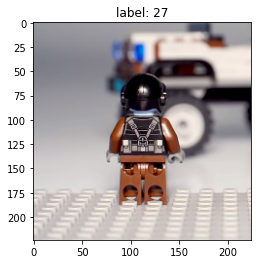

In [4]:
# plot example image
plt.imshow(training_data[15][0])
plt.title("label: {}".format(training_data[15][1].item()));

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. (https://pytorch.org/docs/stable/torchvision/models.html)

In [22]:
# augment and normalize images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
])

transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
])

In [23]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [24]:
X_train = np.array([i[0] for i in training_data])
y_train = np.array([i[1][0] for i in training_data])
X_valid = np.array([i[0] for i in validation_data])
y_valid = np.array([i[1][0] for i in validation_data])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch idx 0, data shape torch.Size([20, 3, 224, 224]), target shape torch.Size([20])
Batch idx 1, data shape torch.Size([20, 3, 224, 224]), target shape torch.Size([20])
Batch idx 2, data shape torch.Size([20, 3, 224, 224]), target shape torch.Size([20])
Batch idx 3, data shape torch.Size([20, 3, 224, 224]), target shape torch.Size([20])
Batch idx 4, data shape torch.Size([20, 3, 224, 224]), target shape torch.Size([20])
Batch idx 5, data shape torch.Size([20, 3, 224, 224]), target shape torch.Size([20])
Batch idx 6, data shape torch.Size([20, 3, 224, 224]), target shape torch.Size([20])
Batch idx 7, data shape torch.Size([20, 3, 224, 224]), target shape torch.Size([20])
Batch idx 8, data shape torch.Size([10, 3, 224, 224]), target shape torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


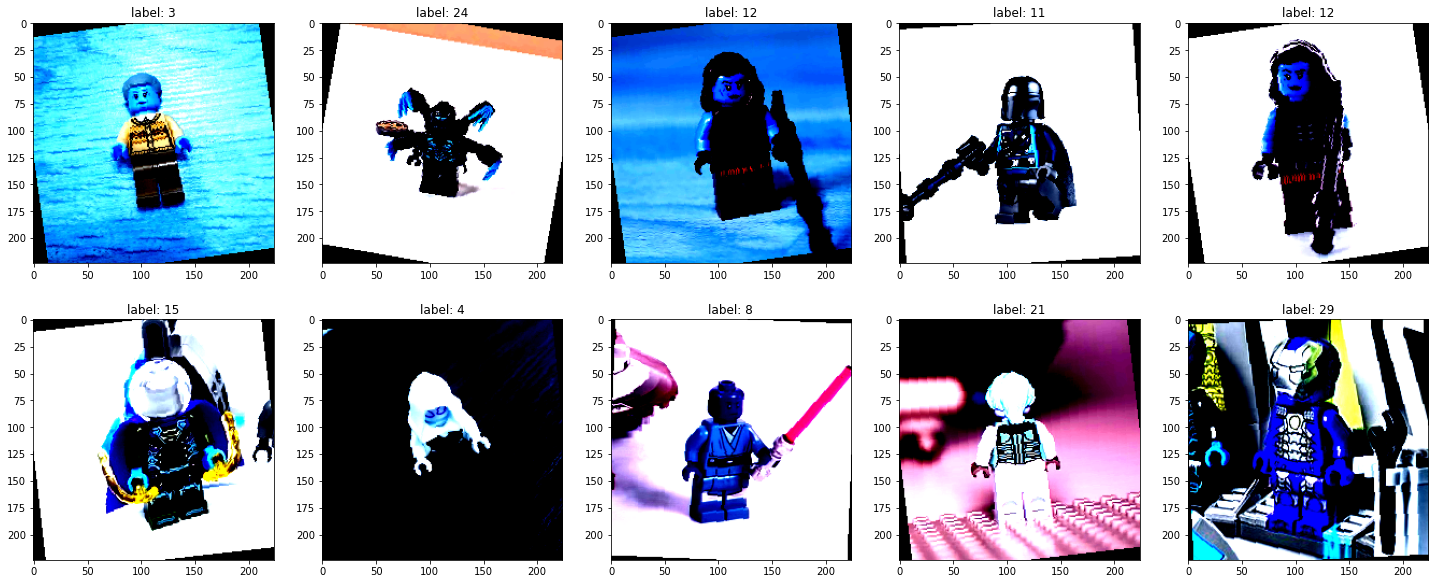

In [25]:
train_dataset = MyDataset(X_train, y_train, transform=transforms)
valid_dataset = MyDataset(X_valid, y_valid, transform=transforms_val)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=20)


for batch_idx, (data, target) in enumerate(train_loader):
    print('Batch idx {}, data shape {}, target shape {}'.format(batch_idx, data.shape, target.shape))
    image_size = data.shape[3]
    
# plot images from last batch
fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()): 
    tmp = data[i].numpy().swapaxes(0,1)
    tmp1 = tmp.swapaxes(1,2)
    
    ax.imshow(tmp1)
    ax.set_title(f"label: {target[i]}");

# Build the Model

In [26]:
# pretrained model
#base_model = models.mobilenet_v2(pretrained=True)
base_model = models.vgg16(pretrained=True)

In [27]:
print(base_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
# Have a look at the final layer
print(base_model.classifier[6].in_features) 
print(base_model.classifier[6].out_features) 

4096
1000


In [29]:
# Freeze all layers until flattening
# This part of the base model is not trained
for param in base_model.features.parameters():
    param.requires_grad = False

In [30]:
# adapt final layer
# input the number of features produced by the base_model
inputs = base_model.classifier[6].in_features

# replace last linear layer (n_inputs -> 30 classes)
# new layers automatically have requires_grad = True
final_layer = nn.Linear(inputs, 30)

base_model.classifier[6] = final_layer

# check last layer number of outputs
print(base_model.classifier[6].out_features)

30


In [31]:
optimizer = optim.Adam(base_model.classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the Model

In [37]:
epochs = 100

for epoch in range(epochs):
    train_loss = 0.0
    
    # model by default is set to train
    
    for batch, (data, target) in enumerate(train_loader):
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = base_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() 
        
        if batch % 20 == 19:    # print training loss every specified number of mini-batches
            print(f'Epoch {epoch}, Batch {batch+1} loss: {(train_loss / 20):.16f}')
            train_loss = 0.0

# Validation